# Implementação em GPU do Algoritmo K-means

Em grande parte baseada na implementação disponível em [dataquestio/kmeans](https://github.com/dataquestio/project-walkthroughs/tree/master/kmeans)

## Imports e Variáveis Globais

In [2]:
import math
import numpy as np
import pandas as pd
import numba

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output



PLOT_RESULTS = True
DEBUG = True

N = 100000
D = 5

K = 3
MAX_ITERATIONS = 500

## Criando o Dataset

- `N` datapoints
- Datapoints `D`-dimensionais
- Floats randomizados ➡ intervalo de [1, 10) (ou [1, 10], dependendo da método de arredondamento de float usado. Isto não deve ter nenhuma relevância estatística, no entanto)

In [4]:
dataset  = [[np.random.uniform(1, 10) for _ in range(D)] for _ in range(N)]
dataset = pd.DataFrame(dataset, columns=[f'd{i}' for i in range(D)])
dataset

,d0,d1,d2,d3,d4
0,9.126242,6.671640,8.405674,6.035250,5.867371
1,8.821473,3.880465,5.121004,8.717300,3.345880
2,1.001936,9.761508,5.236720,6.883222,6.456486
3,4.696457,4.701723,8.899373,1.544026,5.658253
4,8.460069,7.299901,9.951700,1.494694,4.264987
...,...,...,...,...,...
99995,2.178595,9.123704,8.865208,4.244053,2.591179
99996,2.534217,6.702380,7.118187,4.049254,7.518544
99997,5.447919,4.864979,9.469636,6.219870,6.963666
99998,7.631362,7.520759,4.680048,4.894158,1.901077


## K-Means (GPU)

In [7]:

# * ############################################################################
# * Funções auxiliares paralelizadas
# * 
# * Essas são funções vetorizadas que rodarão na GPU. Contém as partes do K-means que mais demandam poder computacional
# * ############################################################################

@numba.guvectorize(
    ['void(float64[:,:], float64[:], float64[:])'],
    '(k,d),(d)->(k)',
    nopython=True,
    target='cuda'
)
def calcDistances(centroids:list[list[np.float64]], rowDataset:list[np.float64], rowResults:list[np.float64]):
    d = len(rowDataset) # Dimensionality

    for centroidIndex, centroid in enumerate(centroids):
        distance = 0.0
        for dim in range(d): distance += (rowDataset[dim] - centroid[dim]) ** 2
        distance = distance ** (1/2)

        rowResults[centroidIndex] = distance


@numba.guvectorize(
    ['void(float64[:],int64[:])'],
    '(k)->()',
    nopython=True,
    target='cuda'
)
def calcClosestCentroids(rowDistances:list[np.float64], closestCent:np.int64):
    minDistance = rowDistances[0]
    minDistanceIndex = 0

    # Retornar o index do valor mínimo em rowDistances
    for index, distance in enumerate(rowDistances):
        if distance < minDistance:
            minDistance = distance
            minDistanceIndex = index

    closestCent[0] = minDistanceIndex


@numba.guvectorize(
    ['void(float64[:],float64[:])'],
    '(d)->(d)',
    nopython=True,
    target='cuda'
)
def calcLogs(rowDataset:list[np.float64], rowResults:list[np.float64]):
    # Calcular o log natural de cada dimensão do datapoint
    for dimIdx, dimValue in enumerate(rowDataset): rowResults[dimIdx] = math.log(dimValue)



# * ############################################################################

def kMeansGPU(dataset:pd.DataFrame, k=3, maxIter=100, plotResults=False, debug=False):
    if plotResults:
        # Inicializando variáveis para exibição gráfica
        pca = PCA(n_components=2) # dois eixos no gráfico
        dataset_2D = pca.fit_transform(dataset.values)

    n = len(dataset)
    d = len(dataset.iloc[0])

    # Gerando centróides iniciais randomicamente
    centroids:pd.DataFrame = pd.concat([(dataset.apply(lambda x: float(x.sample().iloc[0]))) for _ in range(k)], axis=1) # * Paralelizar isto provavelmente é irrelevante, visto que sempre teremos poucos centróides
    centroids_OLD = pd.DataFrame()

    centroids__np = centroids.T.to_numpy()
    centroids_OLD__np = centroids_OLD.T.to_numpy()
    dataset__np = dataset.to_numpy()

    iteration = 1

    while iteration <= maxIter and not np.array_equal(centroids_OLD__np ,centroids__np):
        if plotResults or debug: clear_output(wait=True)
        if debug: debugStr = f'Iteration {iteration}\n\nCentroids:\n{centroids.T}\n\n'

        # Para cada datapoint, calcular distâncias entre ele e cada centróide; depois, encontrar o centróide mais próximo e salvar seu index
        distances = np.zeros((n, k))
        calcDistances(centroids__np, dataset__np, distances)

        if debug: debugStr += f'Distances:\n{distances}\n\n'

        closestCent = np.zeros(n, np.int64)
        calcClosestCentroids(distances, closestCent)
        del distances
        if debug: debugStr += f'Closest centroid index:\n{closestCent}\n\n'

        centroids_OLD__np = centroids__np.copy()

        datasetLogs = np.zeros((n, d))
        calcLogs(dataset__np, datasetLogs)

        # meansByClosestCent[0] = médias dos logs de todos datapoints cujo centróide mais próximo é o centróide de index zero
        meansByClosestCent = np.zeros((k, d))

        for centroidIdx in range(k):
            x = [(True if closestCent[dpIdx] == centroidIdx else False) for dpIdx in range(n)]
            # relevantLogs conterá agora todos itens de datasetLogs cujo datapoint correspondente está mais próximo do centróide de index centroidIdx
            relevantLogs = datasetLogs[x]
            del x
            meansByClosestCent[centroidIdx] = relevantLogs.mean(axis=0)
            del relevantLogs

            centroids__np[centroidIdx] = np.exp(meansByClosestCent[centroidIdx])

        if plotResults:
            # Plotando clusters
            centroids_2D = pca.transform(centroids__np)
            plt.title(f'Iteration {iteration}')
            plt.scatter(x=dataset_2D[:,0], y=dataset_2D[:,1], c=closestCent)
            plt.scatter(x=centroids_2D[:,0], y=centroids_2D[:,1], marker='+', linewidths=2, color='red')
            plt.show()

        if debug: print(debugStr)

        iteration += 1

    return closestCent

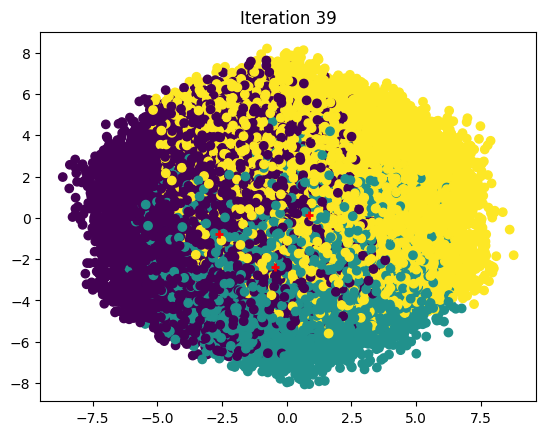

Iteration 39

Centroids:
         d0        d1        d2        d3        d4
0  7.828374  4.702538  4.700940  3.753551  4.731494
1  2.809673  4.800216  4.755183  2.919463  4.721985
2  4.209786  4.733034  4.784615  7.880889  4.799898

Distances:
[[5.07771932 8.23087969 6.75186501]
 [5.32890473 8.52232787 4.99213702]
 [9.23314306 6.84354437 6.2864843 ]
 ...
 [6.28480168 6.71628034 5.56243478]
 [4.1585892  6.5201705  6.0673925 ]
 [4.18609217 3.00128399 5.17826461]]

Closest centroid index:
[0 2 2 ... 2 0 1]




array([0, 2, 2, ..., 2, 0, 1])

In [8]:
# # ! Descomente para rodar de fato
result = kMeansGPU(dataset, K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

result

# Testando com um Dataset Real (Pequeno) — *Iris*

Vamos agora testar esta implementação do k-means usando um dataset real de tamanho bem trivial.

Utilizaremos o [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris), que consiste de dados a respeito de espécimes de [flores do gênero Íris](https://pt.wikipedia.org/wiki/Iris_(g%C3%A9nero)), popularmente chamadas de **Lírios**.

## Dataset

O *Iris* consiste em **150 instâncias**, com dados multivariados de **quatro atributos**:

1. Comprimento da sépala em centímetros
2. Largura da sépala em centímetros
3. Comprimento da pétala em centímetros
4. Largura da pétala em centímetros

Há também um quinto atributo de **Classe**, o **tipo da planta**, que é o que esperamos predizer utilizando o algoritmo. Há **três classes** neste dataset:

- Iris Setosa
- Iris Versicolour
- Iris Virginica

Assim, temos nossas variáveis para execução do k-means:

- `N` = 150
- `D` = 4
- `K` = 3

### Carregando o Dataset

In [11]:
# Imports
from os.path import exists as os_path_exists
from urllib.request import urlopen



# Novas variáveis globais
MAX_ITERATIONS = 100
PLOT_RESULTS = True
DEBUG = True
# ? K será inferido pela quantidade de classes no dataset
# // K = 3



# Função auxiliar
def downloadFileIfNeeded(filePath, url):
    if not os_path_exists(filePath):
        with urlopen(url) as f:
            html = f.read().decode('utf-8')
        with open(filePath, 'w') as f:
            f.write(html)



datasetUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datasetFilePath = './iris.data'
columnNames = ['sepalLen', 'sepalWid', 'petalLen', 'petalWid', 'class']

# Baixando dataset diretamente da internet, se necessário
downloadFileIfNeeded(datasetFilePath, datasetUrl)

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames)

print(dataset)

     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


### Preparando o Dataset

In [13]:
# Transformando a coluna "class" em números (0, 1, …)
classFactorized = dataset['class'].factorize()
# Salvando os nomes de classe na ordem usada pelo .factorize()
classes = list(classFactorized[1])
# // # Sobrescrevendo a coluna do dataset pelos indexes obtidos
# // dataset['class'] = classFactorized[0]

print(f'##### Dataset #####\n{dataset}\n\n')

# Ignorando a coluna "class"
datasetTreated = dataset.drop(['class'], axis=1)
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

# Inferindo número de grupos pela quantidade de classes no dataset
K = len(classes)

##### Dataset #####
     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
     sepalLen  sepalWid  petalLen  petalWid
0        3.00     6.625  1.610169     1.375
1        2.50     4.750  1.610169     1.375
2        2.00     5.500  1.457627     1

## Rodando o K-Means

In [19]:
# Rodando kMeansCPU
results = kMeansGPU(datasetTreated, K, MAX_ITERATIONS)

results

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Conferindo Resultados

Com a tabela `ClosestCentroids` em mãos, temos a classificação de cada instância do dataset *Iris* e, assim, podemos conferir os resultados obtidos através do k-means.

Para isto, basta comparar a segunda coluna da tabela devolvida pelo `kMeansCPU()` com a última coluna do dataset Iris, que informa a classe correta de cada instância.

Essa comparação, no entanto, não é tão simplória de se realizar. Não há como sabermos qual o mapeamento correto entre a classificação feita pelo k-means e as classes reais das instâncias do dataset. Isto é, não há como discernir se o `1` na coluna de classificação de centróides se refere a uma identificação de uma `Iris-versicolor` ao invés de uma `Iris-virginica`, por exemplo.

Por isso, temos que realizar o **maximum matching** atingido pelo resultado do k-means, para realizar uma avaliação justa de seu desempenho.

### Maximum Matching

Teremos que avaliar todas as possibilidades de *mapeamento centróide–classe* e considerar apenas aquela que gera o melhor resultado.

Para isso, é necessário calcular os acertos do resultado diversas vezes. Como há $ k! $ maneiras de se interpretar `K` centróides, isto irá gerar um **custo computacional de $ n \cdot k! $ operações de comparação** entre classificações.

Podemos reduzir este tempo de computação salvando e reaproveitando inteligentemente a quantidade de acertos de classificação computados para cada *mapeamento centróide–classe*.

Por exemplo, há **duas** interpretações dos `K` centróides que possuem um mapeamento `0 -> Iris-Setosa`. São eles: `[Iris-setosa, Iris-versicolor, Iris-virginica]` e `[Iris-setosa, Iris-virginica, Iris-versicolor]`. Ao contar os acertos da primeira destas permutações dos `K` centróides, vamos obter os acertos de linhas do resultado do k-means onde o centróide mais próximo é o de index `0`, e cuja interpreção atual é de este `0` indicar uma flor `Iris-Setosa`. Como iremos usar essa mesma interpretação para centróides de index `0` na próxima permutação, podemos pular essa contagem redundante utilizando o resultado obtido na contagem anterior.

Utilizando este método, conseguimos **reduzir o custo de computação** de acertos de classificação **para $ n^2 $ operações de comparação**!

In [23]:
from itertools import permutations

print(f'result:\n{results}\n')
print(f'dataset:\n{dataset}\n')
print(f'classes:\n{classes}\n')

# Converting from numpy arrays to panda's dataframes, if needed
if results.__class__.__name__ != pd.DataFrame.__class__.__name__: results = pd.DataFrame(results)

def getClassificationHits(results:pd.DataFrame, dataset:pd.DataFrame, classColumn:str|int='class', classes:list[str]=None, debug=False):
    '''Função auxiliar que retorna uma tupla com três informações: (1) a quantidade de acertos de classificação expressos no dataframe `results`; (2) as quantidades destes acertos separadas por classes; e (3) a interpretação das classes usadas para encontrar o melhor resultado
    
    Para determinar acertos e erros, é usada a coluna de nome/index `classColumn` do dataframe `dataset` como fonte de verdade. O maximum matching é feito para encontrar a melhor interpretação dos resultados e usá-la como resultado final

    `results` deve ser um dataframe com duas colunas, a primeira sendo o index do datapoint e a segunda sendo o index da classe à qual o datapoint foi classificado
    
    Uma lista com os nomes das classes pode ser passada em `classes`, para agilizar o processo. Se nada for passado, as classes serão inferidas pela coluna de nome/index `classColumn` do dataframe `dataset`

    Exemplo de retorno: `(118, {'Iris-setosa': 35, 'Iris-versicolor': 39, 'Iris-virginica': 44}, ('Iris-virginica', 'Iris-setosa', 'Iris-versicolor'))`
    
    O retorno acima significa que (1) houveram `118` acertos totais, (2) sendo `35` desses da classe `Iris-setosa`, `39` da classe `Iris-versicolor` e `44` da classe `Iris-virginica` e (3) que a interpretação usada para obter este melhor resultado foi: classe `0` em `results` = `Iris-virginica`, classe `1` = `Iris-setosa` e  classe `2` = `Iris-versicolor`.'''

    def getHitsForClassAndPosition(class_:str, position:int, results:pd.DataFrame=results, dataset:pd.DataFrame=dataset, classColumn:str|int=classColumn):
        '''Função auxiliar interna que calcula os acertos de uma única interpretação de uma única classe
        
        Tal interpretação é expressa em duas variáveis: `class_` -> nome da classe (assim como está expressa na coluna `classColumn` do `dataset`) e `position` -> posição da classe quanto ao array das possíveis k classes ([0, …, k-1] da segunda coluna de `results`)
        
        Exemplo:
        
        `getHitsForClassAndPosition('Iris-setosa', 1)` irá calcular os acertos em `results` ao considerar a classificação de index `1` como simbolizando a classe `Iris-setosa`'''

        hits = 0

        print(f'Counting hits for class "{class_}" being index "{position}" in the results dataset...')

        for rowIndex in range(0, len(results)):
            row = results.iloc[[rowIndex]]
            # datapointIndex = row.index.values[0]
            resultClassIndex = row.values[0]

            # isCorrect = None
            # correctClass = None

            # Conferimos apenas linhas onde o index em "results" é o mesmo em "position", pois só nos importamos com acertos para palpites deste index
            if resultClassIndex == position:
                # Obtendo a classe correta da nossa "fonte de verdade", o dataset "dataset"
                correctClass = dataset.iloc[[rowIndex]][classColumn].values[0]

                # Checando se foi um acerto
                isCorrect = True if str(correctClass) == str(class_) else False
                if isCorrect: hits += 1
                
            # print(f'dpIndex = {datapointIndex}; result = {resultClassIndex}; rowDataset = {correctClass}; isCorrect = {isCorrect}')

        print(f'Total hits: {hits}\n')
        return hits
        return np.random.randint(0, 50 + 1)

    if debug: print('#################### Computing classification hits... ####################\n')

    if classes is None or len(classes) == 0:
        classes = list(dataset[classColumn].factorize()[1])
        if debug: print(f'classes (inferred from `dataset`):\n{classes}\n')

    # Foçar classes para strings
    classes = [str(c) for c in classes]

    # Encontrar todas as permutações possíveis das classes. A posição de uma classe na permutação será usada para atrelar uma classe ao centroid de mesmo index. Por exemplo, na permutação ('Iris-versicolor', 'Iris-setosa', 'Iris-virginica'), o centróide 0 corresponderá à classe 'Iris-versicolor', o centróide 1 à classe 'Iris-setosa' e o centróide 2 à classse 'Iris-virginica'. Cada datapoint terá sua classificação definida através dessa relação
    classPerm = list(permutations(classes))

    if debug:
        print(f'classesPermutatons (len={len(classPerm)}):\n')
        for perm in classPerm: print(perm)
        print('\n')

    # Dicionário auxiliar que guarda a quantidade de acertos por classe e posição na lista de classes. Isto economizará poder computacional, pois não repetiremos cálculos redundantes de hits de uma classe numa mesma posição.
    # Estrutura:
    # {
    #     'Iris-setosa/0': 50,
    #     'Iris-setosa/1': 0,
    #     '<class>/<positionInPermutation>': 45,…
    # }
    hitsByclassAndPosition = {}

    bestHits = -1
    bestHitsPerClass = None
    bestPerm = None

    # Para cada permutação das classes
    for permutation in classPerm:
        # print(f'permutation = {permutation}\n')
        hitsPerClass = dict.fromkeys(classes, -1)

        # Para cada classe na permutação atual
        for classPosition, class_ in enumerate(permutation):
            # Se os hits para essa classe nessa posição da permutação já foram computados, vamos usá-los. Se não, os computamos pela primeira vez e salvamos para usos posteriores
            classAndPositionStr = f'{class_}/{classPosition}' # Chave a ser usada no dicionário
            hits:int = hitsByclassAndPosition.get(classAndPositionStr, None)
            if hits is None:
                # TODO
                # TODO
                # TODO: Implementar o cálculo real dos acertos aqui
                # TODO
                # TODO
                hits = getHitsForClassAndPosition(class_, classPosition)
                hitsByclassAndPosition[classAndPositionStr] = hits

            # Salvando a quantidade de acertos na classe atual, seja qual for
            hitsPerClass[class_] = hits
            # print(f'classPosition = {classPosition}; class_ = {class_}\nhitsPerClass = {hitsPerClass}\nhitsByclassAndPosition = {hitsByclassAndPosition}\n')

        # Computar acertos totais dessa permutação
        totalHits = sum(hitsPerClass.values())

        if totalHits > bestHits:
            bestHits = totalHits
            bestHitsPerClass = hitsPerClass
            bestPerm = permutation

        print(f'totalHits = {totalHits}\nbestHits = {bestHits}; bestHitsPerClass = {bestHitsPerClass}; bestPerm = {bestPerm}\n\n')

    return (bestHits, bestHitsPerClass, bestPerm)



hits, hitsPerClass, centroidClasses  = getClassificationHits(results, dataset, classes=classes, debug=DEBUG)

if DEBUG: print(f'Hits: {hits}\nHits per class: {hitsPerClass}\nCentroid classes: {centroidClasses}\n')

result:
     0
0    0
1    0
2    0
3    0
4    0
..  ..
145  1
146  1
147  1
148  1
149  1

[150 rows x 1 columns]

dataset:
     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]

classes:
['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

#################### Computing classification hits... ############

### Resultados

Rodando a função **`getClassificationHits()`** nos resultados do k-means, encontramos resultados bem esperados:

- Acertos totais entre **130–140**, de 150 classificações (**86,66–93,33%** de acerto)
- Acertos por classe:
  - `Iris-setosa`: quase sempre **50** de 50 (**100%**)
  - `Iris-versicolor`: **35–38** de 50 (**70–76%**)
  - `Iris-virginica`: **45–48** de 50 (**90–96%**)

Estes resultados são exatamente o que esperamos do dataset **Iris**, já que nele temos uma classe linearmente separável (`Iris-setosa`) e duas que NÃO são linearmente separáveis uma da outra (`Iris-versicolor` e `Iris-virginica`).